In [ ]:
!nvidia-smi

Thu Aug  5 21:09:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [ ]:
import gym
import cv2

import time
import json
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

In [ ]:
ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "./pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
#TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)

SAVE_MODELS = False
TRAIN_MODEL = False
LOAD_MODEL_FROM_FILE = True
LOAD_FILE_EPISODE = 800

#LOAD_MODEL_FROM_FILE = False  # Load model from file
#LOAD_FILE_EPISODE = 0  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 100000  # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.97  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.99  # Epsilon decay rate by step

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

In [ ]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

In [ ]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = environment.action_space.n

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def preProcess(self, image):
        """
        Process image crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [ ]:
environment = gym.make(ENVIRONMENT)  # Get env
agent = Agent(environment)  # Create Agent

if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

In [ ]:
last_100_ep_reward_arr = []

total = []

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulkative sum of all steps in episodes
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    state = environment.reset()  # Reset env

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):

        if RENDER_GAME_WINDOW:
            environment.render()  # Show state visually

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done, info = environment.step(action)  # Observe

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            total.append(total_reward)
            last_100_ep_reward_arr.append((episode, np.mean(last_100_ep_reward)))

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")

            break

**Demonstration:**

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
state = environment.reset()  # Reset env
state = agent.preProcess(state)  # Process image
state = np.stack((state, state, state, state))

env = environment

r = 0
for i in range(250):
  action = agent.act(state)
  next_state, reward, done, info = environment.step(action)
  screen = env.render(mode='rgb_array')
  
  next_state = agent.preProcess(next_state) 
  next_state = np.stack((next_state, state[0], state[1], state[2]))
  state = next_state

  r += reward
  print('reward:', r)
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()

**Main algorithm:**

In [ ]:
from tqdm import tqdm_notebook

def SampleSupportPoints(n_traj, t_max, env):
    traj_t = []
    for i in tqdm_notebook(range(n_traj)):
        s = env.reset()

        traj_t.append(env.unwrapped.clone_state())

        s = agent.preProcess(s)  # Process image
        s = np.stack((s, s, s, s))
        
        c = 0
        while True:
            c += 1
            a = agent.act(s)
            new_s, r, done, _ = env.step(a)
            
            if done:
              break

            if c % t_max == 0:
              e_state = env.unwrapped.clone_state()
              traj_t.append(e_state)

            new_s = agent.preProcess(new_s) 
            s = np.stack((new_s, s[0], s[1], s[2]))
  

    return traj_t

In [ ]:
traj_t = SampleSupportPoints(4, 50, env)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
def generate_samples_given(env, X_samples, N=1):
    device = 'cpu'
    rewards0 = []
    rewards1 = []
    rewards2 = []
    rewards3 = []
    for X in X_samples:
        env.reset()
        env.unwrapped.restore_state(X)
        _, r0, _, _ = env.step(0)
        env.reset()
        env.unwrapped.restore_state(X)
        _, r1, _, _ = env.step(1)
        env.reset()
        env.unwrapped.restore_state(X)
        _, r2, _, _ = env.step(2)
        env.reset()
        env.unwrapped.restore_state(X)
        _, r3, _, _ = env.step(3)

        rewards0.append(r0)
        rewards1.append(r1)
        rewards2.append(r2)
        rewards3.append(r3)

    rewards0 = torch.tensor(rewards0, device=device, dtype=torch.float32)
    rewards1 = torch.tensor(rewards1, device=device, dtype=torch.float32)
    rewards2 = torch.tensor(rewards2, device=device, dtype=torch.float32)
    rewards3 = torch.tensor(rewards3, device=device, dtype=torch.float32)
    rewards = torch.cat((rewards0[None, :], rewards1[None, :], rewards2[None, :], rewards3[None, :]), axis=0)

    return torch.FloatTensor(X_samples), rewards

In [ ]:
X_samples_pi, rewards_pi = generate_samples_given(env, traj_t)

In [ ]:
def VpiEstimation(env, X_samples, n_samples, gamma):
    n_actions = 4
    Vpi = []

    step = 0
    for step in tqdm_notebook(range(len(traj_t))):
        average_reward = 0.
        for k in range(n_samples):
            discounted_reward = 0
            env.reset()
            env.unwrapped.restore_state(traj_t[step]) #что это такое?
            
            s, _, _, _ = env.step(0)
            s = agent.preProcess(s)  # Process image 
            s = np.stack((s, s, s, s))
            a = agent.act(s)

            cur_gamma = 1.

            while True:

              new_s, r, done, _ = env.step(a)
              new_s = agent.preProcess(new_s) 
              s = np.stack((new_s, s[0], s[1], s[2]))

              a = agent.act(s)
              discounted_reward += cur_gamma * r
              cur_gamma *= gamma

              if done:
                break

            average_reward += discounted_reward

        Vpi.append(average_reward / n_samples)
        #print(step, average_reward / n_samples)
    return torch.tensor(Vpi, dtype=torch.float32)

In [ ]:
V_pi2 = VpiEstimation(env, traj_t, 1, gamma=0.9999)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
import sklearn
from tqdm import trange 
from IPython.display import display
from IPython.display import clear_output

In [ ]:
def getMonteCarloUpperBounds(env, X_samples, rewards, V_pi, k=4, total_steps=50, M1=15, M2=15, gamma=0.99):
    """
    0,1,2,3 means action 
    """
    max_grad_norm = 5000
    loss_history = []
    grad_norm_history = []
    eval_freq = 1
    device = 'cpu'

    #state_dim, n_actions = env.observation_space.shape, env.action_space.n
    state_dim, n_actions = env.observation_space.shape, 4
    # X_samples, rewards = generate_samples_uniform(env, 2000)
    #N = X_samples.shape[0]
    N = len(X_samples)
    neigh = NearestNeighbors(n_neighbors=5, algorithm='kd_tree', leaf_size=30, n_jobs=-1)
    #neigh.fit(X_samples.tolist())
    neigh.fit(X_samples)
    rewards = rewards.reshape(n_actions, N, 1)
    # V_pi = VpiEstimation(X_samples, policy)
    V_up = torch.clone(V_pi) + 7
    #perm = torch.randperm(X_samples.size(0))
    perm = torch.randperm(N)
    idx = perm[:50] #for output
    #idx = range(N)
    N_states = 50
    samples = np.array(X_samples)[idx] #for output
    single_sample = np.random.randint(0, len(X_samples), size=1)
    upper_bound_sample = []
    # print(X_samples[0])
    # assert False
    upper_list = [V_up.numpy()]
    norm_list_upper = []
    step = 0
    YX0 = []
    YX1 = []
    YX2 = []
    YX3 = []
    for i in range(N):
        YX0j = []
        YX1j = []
        YX2j = []
        YX3j = []
        for j in range(M1):
            env.reset()
            env.unwrapped.restore_state(X_samples[i])
            YXi0, _, _, _ = env.step(0)
            YXi0 = env.unwrapped.clone_state()

            env.reset()
            env.unwrapped.restore_state(X_samples[i])
            YXi1, _, _, _ = env.step(1)
            YXi1 = env.unwrapped.clone_state()
            
            env.reset()
            env.unwrapped.restore_state(X_samples[i])
            YXi2, _, _, _ = env.step(2)
            YXi2 = env.unwrapped.clone_state()

            env.reset()
            env.unwrapped.restore_state(X_samples[i])
            YXi3, _, _, _ = env.step(3)
            YXi3 = env.unwrapped.clone_state()

            YX0j.append(YXi0)
            YX1j.append(YXi1)
            YX2j.append(YXi2)
            YX3j.append(YXi3)

        YX0.append(YX0j)
        YX1.append(YX1j)
        YX2.append(YX2j)
        YX3.append(YX3j)

    YX0 = torch.tensor(YX0, device=device, dtype=torch.float32)
    YX1 = torch.tensor(YX1, device=device, dtype=torch.float32)
    YX2 = torch.tensor(YX2, device=device, dtype=torch.float32)
    YX3 = torch.tensor(YX3, device=device, dtype=torch.float32)

    Yxa_M1 = torch.cat((YX0[None, :, :, :], YX1[None, :, :, :], YX2[None, :, :, :], YX3[None, :, :, :]), axis=0)
    _, idxes_neigh1 = neigh.kneighbors(torch.flatten(Yxa_M1, end_dim=2).numpy().tolist())
    V_pi1 = V_pi[torch.tensor(idxes_neigh1)].mean(dim=-1).reshape(n_actions, N, M1)
    V_mean = torch.mean(V_pi1, dim=-1) #same shape as rewards
    V_mean = V_mean.reshape(n_actions, N, 1)
    with trange(step, total_steps + 1) as progress_bar:
        for step in progress_bar:
            YX0 = []
            YX1 = []
            YX2 = []
            YX3 = []
            for i in range(N):
                YX0j = []
                YX1j = []
                YX2j = []
                YX3j = []
                for j in range(M2):
                    env.reset()
                    env.unwrapped.restore_state(X_samples[i])
                    YXi0, _, _, _ = env.step(0)
                    YXi0 = env.unwrapped.clone_state()

                    env.reset()
                    env.unwrapped.restore_state(X_samples[i])
                    YXi1, _, _, _ = env.step(1)
                    YXi1 = env.unwrapped.clone_state()
            
                    env.reset()
                    env.unwrapped.restore_state(X_samples[i])
                    YXi2, _, _, _ = env.step(2)
                    YXi2 = env.unwrapped.clone_state()

                    env.reset()
                    env.unwrapped.restore_state(X_samples[i])
                    YXi3, _, _, _ = env.step(3)
                    YXi3 = env.unwrapped.clone_state()

                    YX0j.append(YXi0)
                    YX1j.append(YXi1)
                    YX2j.append(YXi2)
                    YX3j.append(YXi3)

                YX0.append(YX0j)
                YX1.append(YX1j)
                YX2.append(YX2j)
                YX3.append(YX3j)

            YX0 = torch.tensor(YX0, device=device, dtype=torch.float32)
            YX1 = torch.tensor(YX1, device=device, dtype=torch.float32)
            YX2 = torch.tensor(YX2, device=device, dtype=torch.float32)
            YX3 = torch.tensor(YX3, device=device, dtype=torch.float32)
            Yxa_M2 = torch.cat((YX0[None, :, :, :], YX1[None, :, :, :], YX2[None, :, :, :], YX3[None, :, :, :]), axis=0)
            #Yxa has shape (2, N, M1 + M2, 4)
            _, idxes_neigh2 = neigh.kneighbors(torch.flatten(Yxa_M2, end_dim=2).numpy().tolist())
            V_pi2 = V_pi[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)
            V_k = V_up[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)

            M = V_pi2 - V_mean
            # EM = torch.mean(M, dim=-1)
            # DM = torch.sum(M**2, dim=-1) / (M.shape[-1] - 1)
            #M has shape (n_actions, N, M2)
            V_up = (rewards + gamma * (V_k - M)).max(dim=0)[0].mean(dim=-1)

            if step % eval_freq == 0:
                clear_output(True)
                plt.figure(figsize=(15, 10))
                plt.subplot(121)
                lower = V_pi[idx].numpy()
                upper = V_up[idx].numpy()
                upper_list.append(upper)
                upper_bound_sample.append(V_up[single_sample])
                upper_plot = np.repeat(upper.reshape(-1, 1), repeats=2, axis=1).reshape(-1)
                lower_plot = np.repeat(lower.reshape(-1, 1), repeats=2, axis=1).reshape(-1)
                states_plot = np.concatenate((np.arange(N_states).reshape(-1,1),
                                          (np.arange(N_states)+1).reshape(-1,1)), axis=1).reshape(-1)
                plt.fill_between(states_plot, lower_plot, upper_plot, alpha=0.3,
                            edgecolor='k', linestyle='-')
                plt.plot(states_plot, upper_plot, 'b')
                plt.legend(loc="upper left", fontsize=14)
                plt.xlabel("State", fontsize=25)
                #plt.xticks(np.arange(N_states + 1))
                plt.xticks(size = 15)
                plt.yticks(size = 15)   
                plt.title("Upper and Lower bounds", fontsize = 30)


                plt.subplot(122)
                if step >= 1:
                    norm_upper = np.linalg.norm(upper_list[-2] - upper_list[-1])
                    norm_list_upper.append(norm_upper)
                    plt.plot(norm_list_upper)
                    plt.title("Upper norm", fontsize = 30)
                    plt.xticks(size = 15)
                    plt.yticks(size = 15)
                plt.show()
                if step == total_steps - 1:
                    plt.savefig('pic1.png')
                # clear_output(True)
                # plt.figure(figsize=[16, 9])

                # assert not np.isnan(loss_history[-1])
                # plt.subplot(1, 2, 1)
                # plt.title("loss history")
                # # plt.plot(utils.smoothen(loss_history))
                # plt.plot(loss_history)
                # plt.grid()

                # plt.subplot(1, 2, 2)
                # plt.title("Grad norm history")
                # # plt.plot(utils.smoothen(grad_norm_history))
                # plt.plot(grad_norm_history)
                # plt.grid()
                # plt.show()


    return V_up, V_pi, X_samples.numpy(), upper_bound_sample

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

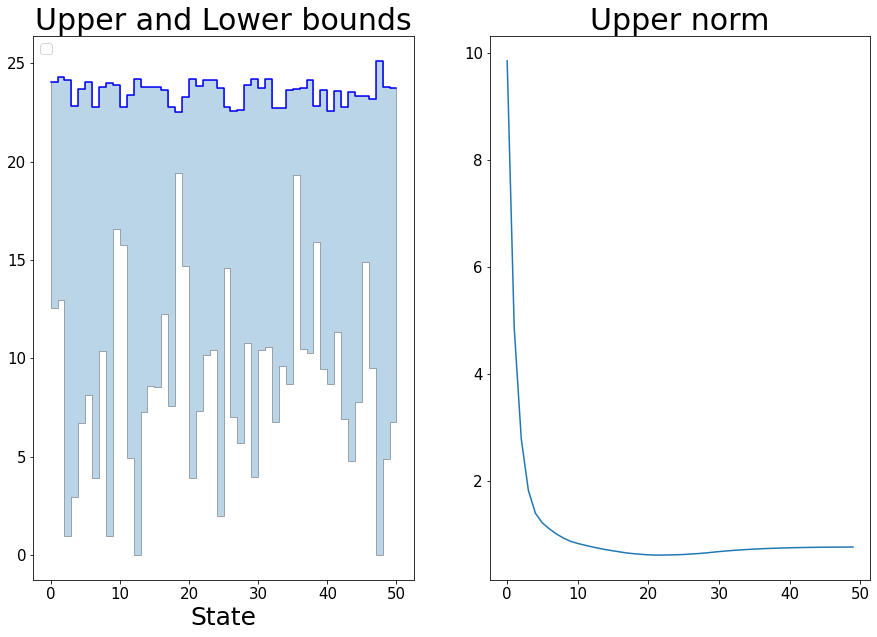

100%|██████████| 51/51 [1:12:48<00:00, 85.65s/it]


AttributeError: ignored

In [ ]:
V_up, V_pi, samples, upper_bound_sample = getMonteCarloUpperBounds(env, traj_t, rewards_pi, V_pi2, gamma=0.9999)